In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)     # Input (28, 28, 1) >> Output (28, 28, 32) >> Rf = 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Input (28, 28, 32) >> Output (28, 28, 64) >> Rf = 5
        self.pool1 = nn.MaxPool2d(2, 2)                 # Input (28, 28, 64) >> Output (14, 14, 64) >> Rf = 6
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Input (14, 14, 64) >> Output (14, 14, 128) >> Rf = 10
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Input (14, 14, 128) >> Output (14, 14, 256) >> Rf = 14
        self.pool2 = nn.MaxPool2d(2, 2)                 # Input (14, 14, 256) >> Output (7, 7, 256) >> Rf = 16
        self.conv5 = nn.Conv2d(256, 512, 3)             # Input (7, 7, 256) >> Output (5, 5, 512) >> Rf = 24
        self.conv6 = nn.Conv2d(512, 1024, 3)            # Input (5, 5, 512) >> Output (3, 3, 1024) >> Rf = 32
        self.conv7 = nn.Conv2d(1024, 10, 3)             # Input (3, 3, 1024) >> Output (1, 1, 10) >> Rf = 40

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 

<ipython-input-2-95e189b1b3b3>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [4]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


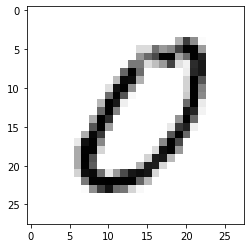

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[5].numpy().squeeze(), cmap='gray_r')

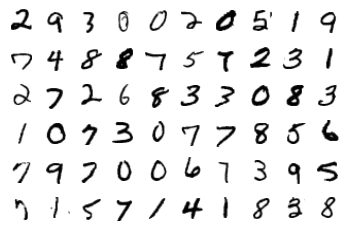

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [10]:
from tqdm import tqdm

train_losses = []
train_accs = []
test_losses = []
test_accs= []

def train(model, device, train_loader, optimizer, epoch):
    correct_preds = 0
    processed = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Porting the data and targets in to the GPU
        data, target = data.to(device), target.to(device)

        # setting all the gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Loss calculation 
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Back propogation
        loss.backward()

        # Updating the weights with calculated gradients
        optimizer.step()

        # Calculating the correct number of predictions
        preds = output.argmax(dim=1, keepdim=True)
        correct_preds += preds.eq(target.view_as(preds)).sum().item()
        processed += len(data)
        
        # Logging the results using Pbar
        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct_preds/processed:0.2f}')

        # Appending the training accuracies to the train_accs[]
        train_accs.append(100*correct_preds/processed)
        


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Porting the data and targets in to the GPU
            data, target = data.to(device), target.to(device)

            # Predict 
            output = model(data)

            # Test loss calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accs.append(100. * correct / len(test_loader.dataset))

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 15
for epoch in range(0, num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-2-95e189b1b3b3>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch=0 Loss=0.268068790435791 Batch_id=468 Accuracy=56.75: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.3102, Accuracy: 8795/10000 (87.95%)



Epoch=1 Loss=0.039137255400419235 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0422, Accuracy: 9857/10000 (98.57%)



Epoch=2 Loss=0.0338645838201046 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0418, Accuracy: 9843/10000 (98.43%)



Epoch=3 Loss=0.01384416501969099 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0326, Accuracy: 9893/10000 (98.93%)



Epoch=4 Loss=0.009790289215743542 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)



Epoch=5 Loss=0.008766182698309422 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.15%)



Epoch=6 Loss=0.007975418120622635 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]



Test set: Average loss: 0.0349, Accuracy: 9881/10000 (98.81%)



Epoch=7 Loss=0.0027116776909679174 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)



Epoch=8 Loss=0.003302070079371333 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)



Epoch=9 Loss=0.0006434397073462605 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)



Epoch=10 Loss=0.0008908468880690634 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)



Epoch=11 Loss=0.0006443696329370141 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)



Epoch=12 Loss=0.0005686737713404 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)



Epoch=13 Loss=7.921818905742839e-05 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]



Test set: Average loss: 0.0260, Accuracy: 9930/10000 (99.30%)



Epoch=14 Loss=0.00017007211863528937 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]



Test set: Average loss: 0.0253, Accuracy: 9933/10000 (99.33%)



In [12]:
import numpy 
train_losses = [i.cpu().detach().numpy() for i in train_losses]

In [13]:
test_losses = [i for i in test_losses]
train_accs = [i for i in train_accs]
test_accs = [i for i in test_accs]

Text(0.5, 1.0, 'Test Accuracy')

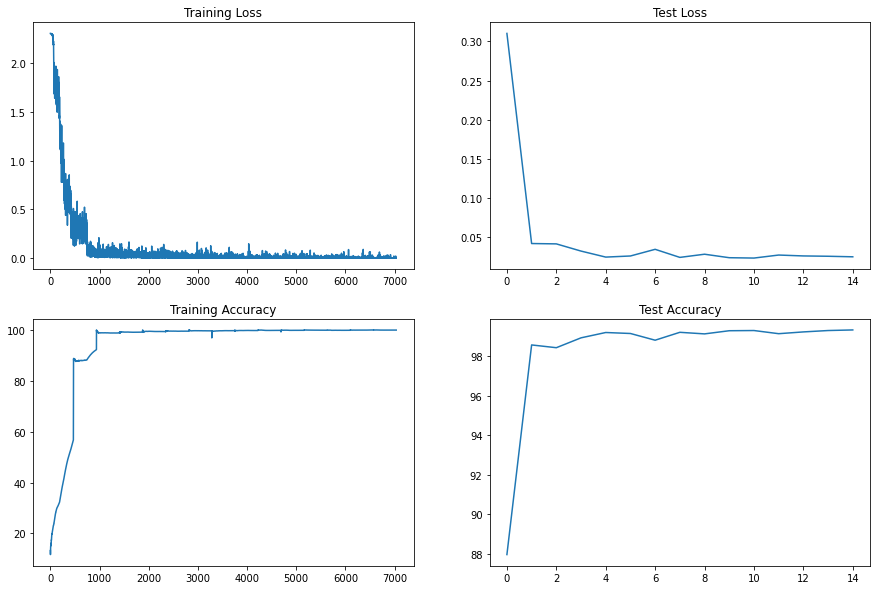

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")